# Example: MNIST with Babilim

> A babilim example to solve fashion MNIST with a gpu.

Before we start with the solving, make sure you have installed babilim and pytorch (or tf2).

```bash
conda activate my_env_name
conda install pytorch torchvision cudatoolkit=10.1 -c pytorch
pip install babilim
```

Then to start, we setup babilim to use the backend of choice in our notebook and set the debug verbosity high.

In [1]:
import babilim

babilim.DEBUG_VERBOSITY = True
babilim.set_backend(babilim.PYTORCH_BACKEND)

[2020-01-20 15:48:20] INFO Using backend: pytorch-gpu


## Defining the Problem

MNIST contains images of numbers 0-9.
The images are grayscale and have a resolution of 28x28.
For every image the number that has been written is annotated as an integer number.

We want to build a neural network that predicts the number given the image.
Typically the input to the neural network can be called features or image (we chose features, since it is more generic here).
The output in this case can be seen as a classification problem.
We have classes from 0  to 9 which are mutually exclusive, since a prediction can be only one number.
However classes should be prefered over regression, since they can model uncertainty between 8 and 2 better by assigning both high probabilities, whereas regression would yield 5 (which is completely wrong).

Those decisions lead to a problem definition as follows:

$
\texttt{features} \rightarrow \texttt{class-id}
$

In [2]:
# e.g.: definitions/mnist.py
from collections import namedtuple

# Create some named tuple for our inputs and outputs so we do not confuse them.
NetworkInput = namedtuple("NetworkInput", ["features"])
NetworkOutput = namedtuple("NetworkOutput", ["class_id"])

## Defining a configuration

Whereas we anticipate running multiple experiments over the course of the development, we want to have all configuration choices in one config class, so we can easily track the experiments.

At the beginning this class will be created empty and then filled with life over time.
In this example it will directly come with all variables required, since this cell has been edited multiple times during the development process.



In [3]:
# e.g.: configs/mnist.py
from babilim.core import Config
from babilim.training.optimizers import learning_rates


class FashionMnistConfig(Config):
    def __init__(self):
        super().__init__()
        self.problem_number_of_categories = 10
        self.problem_samples = 60000
        self.problem_base_dir = "datasets"

        self.train_epochs = 20
        self.train_l2_weight = 0.01
        self.train_batch_size = 32
        self.train_log_steps = 100
        self.train_experiment_name = "FashionMNIST"
        self.train_checkpoint_path = "checkpoints"
        samples_per_epoch = self.problem_samples / self.train_batch_size
        self.train_learning_rate_shedule = learning_rates.Exponential(initial_lr=0.001, k=0.1 / samples_per_epoch)


# Create a config (should be in your main function)
config = FashionMnistConfig()

## Trinity of Dataset, Model, Trainer

In every deep learning problem there is the trinity of the dataset, the model and the trainer.
If any of the parts is weak, the overall result will be unsatisfactory.

This means we want to ensure that all parts work equally good.
Without good data, a good model is of no use at all.
So  we will start with the dataset and explore it.

This is typically a good way to start, whereas model choice is dependant on the data.

## Dataset

In the case of MNIST we are in a comfortable spot, whereas the dataset is already balanced, and nicely preprocessed.
All images are centered, have the same size and have good contrast.
However, we will use a transformer which does not change the data, to show how a tranformer would work.

The dataset can be easily implemented using tensorflow and pytorch libraries, whereas they provide loaders for the data already.
This gives us a chance to show writing specific code for a backend.

In [4]:
# e.g.: datasets/mnist.py
import babilim
import numpy as np
from babilim import TF_BACKEND, PHASE_TRAIN
from babilim.data import Dataset
from typing import Tuple


class FashionMnistDataset(Dataset):
    def __init__(self, config: FashionMnistConfig, phase: str):
        super().__init__(config)
        self.training = phase == PHASE_TRAIN
        
        if babilim.is_backend(TF_BACKEND):
            from tensorflow.keras.datasets import fashion_mnist
            ((trainX, trainY), (valX, valY)) = fashion_mnist.load_data()
            if self.training:
                self.inp = trainX
                self.outp = trainY
            else:
                self.inp = valX
                self.outp = valY
        else:
            from torchvision.datasets import FashionMNIST
            dataset = FashionMNIST(config.problem_base_dir, train=phase==PHASE_TRAIN, download=True)
            self.inp = []
            self.outp = []
            for x, y in dataset:
                self.inp.append(x)
                self.outp.append(y)

    def __len__(self) -> int:
        return int(len(self.inp))

    def getitem(self, idx: int) -> Tuple[NetworkInput, NetworkOutput]:
        feat = np.array(self.inp[idx], dtype="float32")
        label = np.array(self.outp[idx], dtype="uint8")
        
        feat = np.reshape(feat, (28, 28))
        return NetworkInput(features=feat), NetworkOutput(class_id=label)

    @property
    def version(self) -> str:
        return "FashionMnistDataset"

Now we will write a simple transformer that makes the data readable for the neural network training.

The transformer will make an image grid out of the feature, so it can be used in tensorflow or pytorch, since one has channel first and the other channel last representation.

In [5]:
# e.g.: datasets/mnist_transformers.py
from babilim.data import Transformer, image_grid_wrap
from typing import Tuple


class MNISTTransformer(Transformer):
    def __init__(self):
        pass
    
    def __call__(self, inp: NetworkInput, outp: NetworkOutput) -> Tuple[NetworkInput, NetworkOutput]:
        return NetworkInput(features=image_grid_wrap(inp.features)), outp
    
    @property
    def version(self):
        return "MNISTTransformer"

The dataset is created and then a transformer is appended to the transformers.
There are two types of transformers: `dataset::transformers` and `dataset::realtime_transformers`.
The difference between the two is that the realtime_transformers get applied after caching and the transformers before caching.

> Important: Realtime transformers should contain easy and quick computations to avoid slowing down your training and data augmentation should be done in realtime transformers or it will only be applied once (before caching).

In [6]:
# Create the dataset and setup the transformers (should be in your main function)
from babilim import PHASE_VALIDATION, PHASE_TRAIN


train = FashionMnistDataset(config, PHASE_TRAIN)
val = FashionMnistDataset(config, PHASE_VALIDATION)
transformer = MNISTTransformer()
train.realtime_transformers.append(transformer)
val.realtime_transformers.append(transformer)

One last step is to test if the dataset works.
To test this we will call the dataset with multiple random indices.
(The images you will see when executing might differ.)
Normally this test would be much more detailed, checking the value ranges of your data, if everything is aligned and as expected, but in this simple example we will only do a visual inspection.

Training


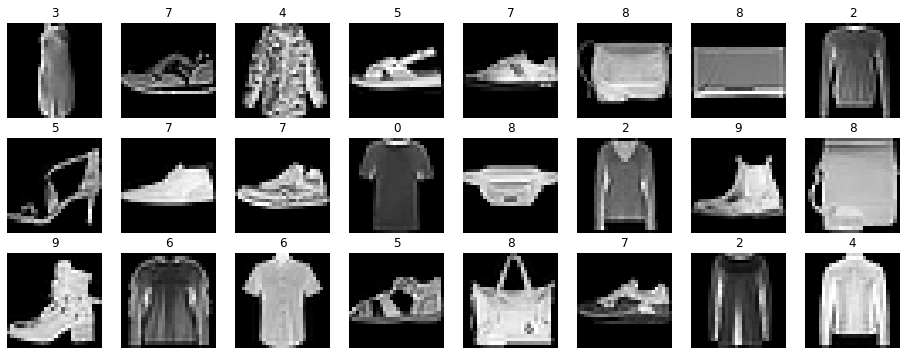

Validation


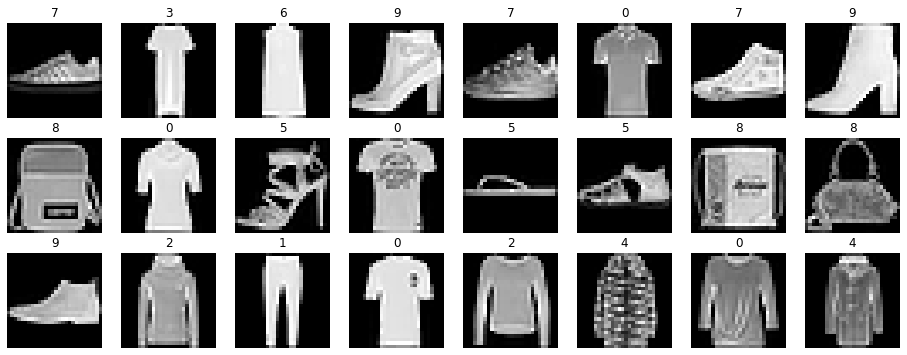

In [7]:
# e.g. tests/mnist_visualization.py
import matplotlib.pyplot as plt
import random
from babilim.data import image_grid_unwrap

print("Training")
plt.figure(figsize=(16,6))
for i in range(24):
        idx = random.randint(0, len(train))
        feat, label = train[idx]
        plt.subplot(3, 8, i + 1)
        plt.axis('off')
        plt.title(label.class_id)
        plt.imshow(image_grid_unwrap(feat.features)[:,:,0], cmap='gray', vmin=0, vmax=255)
plt.show()

print("Validation")
plt.figure(figsize=(16,6))
for i in range(24):
        idx = random.randint(0, len(train))
        feat, label = train[idx]
        plt.subplot(3, 8, i + 1)
        plt.axis('off')
        plt.title(label.class_id)
        plt.imshow(image_grid_unwrap(feat.features)[:,:,0], cmap='gray', vmin=0, vmax=255)
plt.show()

## The Model

After having implemented and tested the dataloader.
We can move to the next step: Implementing the model.

This will actually be a suprisingly small part of this tutorial, since it is so easy with modern frameworks.

### CNN

The problem is classifying images into the clothing type, therefore a convolutional neural network is the right model choice.
If you do not now what a CNN is, please refer to one of the plenty resources available on the internet.

We will use a CNN inspired by VGG 16.
So it wil have convolutions followed by a few fully connected layers.

### Implementation

The model has an `__init__`, a `build`, and a `call`-function that need to be implemented.

The `build`-function with the `@RunOnlyOnce`-annotation will be run only once and build the model initially.
It has available knowledge on the shape of the input tensors.

The `call`-function is the actual forward pass of the model and typically trivial to implement when using the build-call pattern.

In [8]:
# e.g. model/mnist.py
from babilim.core import ITensor, RunOnlyOnce
from babilim.model.module import Module
from babilim.model.modules import BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Linear, Activation, Flatten


class FashionMnistModel(Module):
    def __init__(self, config: FashionMnistConfig):
        super().__init__(layer_type="FashionMnistModel")
        self.config = config
        self.linear = []

    @RunOnlyOnce
    def build(self, features: ITensor):
        out_features = self.config.problem_number_of_categories

        self.linear.append(BatchNormalization())
        self.linear.append(Conv2D(filters=12, kernel_size=(3, 3)))
        self.linear.append(Activation("relu"))
        self.linear.append(MaxPooling2D())

        self.linear.append(BatchNormalization())
        self.linear.append(Conv2D(filters=18, kernel_size=(3, 3)))
        self.linear.append(Activation("relu"))
        self.linear.append(MaxPooling2D())

        self.linear.append(BatchNormalization())
        self.linear.append(Conv2D(filters=18, kernel_size=(3, 3)))
        self.linear.append(Activation("relu"))
        self.linear.append(MaxPooling2D())

        self.linear.append(BatchNormalization())
        self.linear.append(Conv2D(filters=18, kernel_size=(3, 3)))
        self.linear.append(Activation("relu"))
        self.linear.append(GlobalAveragePooling2D())

        self.linear.append(BatchNormalization())
        self.linear.append(Flatten())
        self.linear.append(Linear(out_features=18))
        self.linear.append(Activation("relu"))
        self.linear.append(Linear(out_features=out_features))

    def call(self, features: ITensor) -> NetworkOutput:
        net = features
        for l in self.linear:
            net = l(net)
        return NetworkOutput(class_id=net)


# Create the model and initialize it (should be in your main function)
model = FashionMnistModel(config)
model.initialize(train)

[2020-01-20 15:48:25] INFO Build Model


Testing the model is important to see if it works and transforms the data as expected.
The output will not be correct but should appear random.

Training


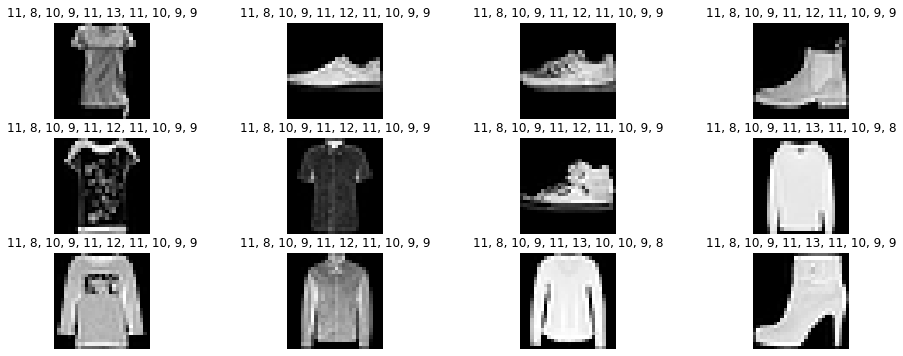

Validation


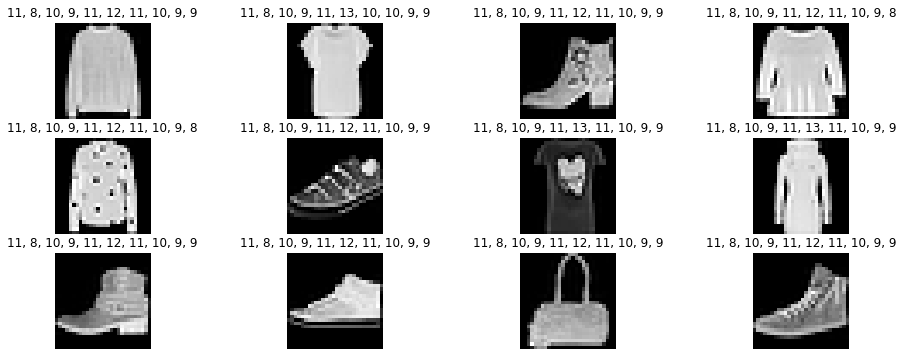

In [9]:
# e.g. test/mnist_model.py
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    x = np.array(x)
    return np.exp(x) / np.sum(np.exp(x), axis=0)

model.eval()
print("Training")
plt.figure(figsize=(16,6))
for i in range(12):
        idx = random.randint(0, len(train))
        feat, label = train[idx]
        pred = model.predict(**feat._asdict())
        plt.subplot(3, 4, i + 1)
        plt.axis('off')
        class_probs = softmax(pred.class_id)
        plt.title(", ".join(["{:.0f}".format(x*100) for x in class_probs]))
        plt.imshow(image_grid_unwrap(feat.features)[:,:,0], cmap='gray', vmin=0, vmax=255)
plt.show()

print("Validation")
plt.figure(figsize=(16,6))
for i in range(12):
        idx = random.randint(0, len(train))
        feat, label = train[idx]
        pred = model.predict(**feat._asdict())
        plt.subplot(3, 4, i + 1)
        plt.axis('off')
        class_probs = softmax(pred.class_id)
        plt.title(", ".join(["{:.0f}".format(x*100) for x in class_probs]))
        plt.imshow(image_grid_unwrap(feat.features)[:,:,0], cmap='gray', vmin=0, vmax=255)
plt.show()
model.train()

## The Trainer

Having implemented a model, the trainer is the remaining part.
The trainer will fit the model to the dataset and consists of multiple parts.

The loss, metrics, an optimizer and the trainer itself.

### Loss

In [10]:
# e.g. training/mnist_loss.py
from babilim.training.losses import Loss, SparseCrossEntropyLossFromLogits


class FashionMnistLoss(Loss):
    def __init__(self):
        super().__init__()
        self.ce = SparseCrossEntropyLossFromLogits()

    def call(self, y_pred: NetworkOutput, y_true: NetworkOutput) -> ITensor:
        return self.ce(y_pred.class_id, y_true.class_id).mean()


# Create the loss (should be in your main function)
loss = FashionMnistLoss()

### Metrics

In [11]:
# e.g. training/mnist_metrics.py
from babilim.training.losses import Metrics, SparseCrossEntropyLossFromLogits, SparseCategoricalAccuracy


class FashionMnistMetrics(Metrics):
    def __init__(self):
        super().__init__()
        self.ce = SparseCrossEntropyLossFromLogits()
        self.ca = SparseCategoricalAccuracy()

    def call(self, y_pred: NetworkOutput, y_true: NetworkOutput) -> None:
        self.log("ce", self.ce(y_pred.class_id, y_true.class_id).mean())
        self.log("ca", self.ca(y_pred.class_id, y_true.class_id).mean())


# Create the metrics (should be in your main function)        
metrics = FashionMnistMetrics()

### Training

In [12]:
# e.g. training/mnist_train.py (contain all stuff annotated with "should be in your main function" and this cell)
from babilim.core import Config, logger
from babilim.training import supervised
from babilim.training.optimizers import SGD

logger.setup(config, continue_training=False)

# Create optimizer
optim = SGD()

# Fit our model to the data using our loss and report the metrics.
supervised.fit(model, train, val, loss, metrics, config, optim, config.train_learning_rate_shedule, verbose=True)

[2020-01-20 15:48:30] INFO Build Model
[2020-01-20 15:48:30] INFO Trainable Variables:
[2020-01-20 15:48:30] INFO   /linear/0/bn/weight: (1,)
[2020-01-20 15:48:30] INFO   /linear/0/bn/bias: (1,)
[2020-01-20 15:48:30] INFO   /linear/1/weight: (12, 1, 3, 3)
[2020-01-20 15:48:30] INFO   /linear/1/bias: (12,)
[2020-01-20 15:48:30] INFO   /linear/4/bn/weight: (12,)
[2020-01-20 15:48:30] INFO   /linear/4/bn/bias: (12,)
[2020-01-20 15:48:30] INFO   /linear/5/weight: (18, 12, 3, 3)
[2020-01-20 15:48:30] INFO   /linear/5/bias: (18,)
[2020-01-20 15:48:30] INFO   /linear/8/bn/weight: (18,)
[2020-01-20 15:48:30] INFO   /linear/8/bn/bias: (18,)
[2020-01-20 15:48:30] INFO   /linear/9/weight: (18, 18, 3, 3)
[2020-01-20 15:48:30] INFO   /linear/9/bias: (18,)
[2020-01-20 15:48:30] INFO   /linear/12/bn/weight: (18,)
[2020-01-20 15:48:30] INFO   /linear/12/bn/bias: (18,)
[2020-01-20 15:48:30] INFO   /linear/13/weight: (18, 18, 3, 3)
[2020-01-20 15:48:30] INFO   /linear/13/bias: (18,)
[2020-01-20 15:48:30

KeyboardInterrupt: 

In [17]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]

'1'